## 3. 평가

- 분류의 성능 평가 지표
  - 정확도(Accuracy)
  - 오차행렬(Confusion Matrix)
  - 정밀도(Precision)
  - 재현율(Recall)
  - F1 스코어
  - ROC AUC

### 3-1. 정확도(Accuracy)

$$ 정확도 = \frac{예측\,결과가\,동일한\,데이터\,건수}{전체\,예측\,데이터\,건수}  $$
단순한 알고리즘으로 예측을 하더라도 데이터 구성에 따라 정확도가 높게 나올 수 있음  
ex) 불균형한 레이블 값 분포에서는 적합한 평가 지표 X  
=>  정확도를 평가 지표로 사용할 떄에는 신중해야함  


In [56]:
# titanic 데이터를 활용해서 학습 없이 성별만으로 분류를 수행하는 알고리즘 생성

from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):

    def fit(self, X, y=None): # 아무것도 학습 X
        pass

    def predict(self, X):     # sex=1이면 0, 그렇지 않으면 1로 예측
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] =1
        
        return pred

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing


# 전처리 함수들 불러오기(2장 참고)
def fillna(df):   # 결측치 처리 함수
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df
def drop_features(df): # 불필요한 피쳐 제거 함수
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

def format_features(df):   # 레이블 인코딩 함수
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df
def transform_features(df):  # 위에서 설정한 함수들 모두 호출하는 함수
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

# 데이터 불러오기
titanic_df = pd.read_csv('/Users/dayoungcho/Desktop/kaggle/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 분류 알고리즘에 적용
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
mypredictions = myclf.predict(X_test)

print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test,mypredictions)))

Dummy Classifier의 정확도는: 0.7877


In [58]:
## MNIST 데이터셋의 레이블을 불균형하게 만들어서 정확도를 측정해보기

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd


class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    def predict(self,X):   # 입력값으로 들어오는 데이터셋(X)의 크기만큼 모두 0으로 만들어서 반환
        return np.zeros((len(X), 1), dtype = bool)
    

digits = load_digits() # 데이터 로딩

y = (digits.target==7).astype(int)# 7번이면 True이고 1로 변환, 7이 아니면 False이고 0으로 변환

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

In [59]:
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts()) # 분포가 매우 불균형

fakeclf = MyFakeClassifier()            # 분류 실시
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)

print('모든 예측을 0으로 하여도 정확도는 {:.3f}'.format(accuracy_score(y_test, fakepred)))  # 아무렇게나 예측해도 정확도 높음

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는 0.900


### 3-2. 오차 행렬

![image](https://images.prismic.io/encord/edfa849b-03fb-43d2-aba5-1f53a8884e6f_image5.png?auto=compress,format)

In [60]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

불균형한 이진 분류 데이터셋에서는 주로 Positive 데이터 건수가 작기 때문에 Negative로 예측 정확도가 높아지는 경향  
=> Negative에 대한 예측 정확도마으로 분류의 정확도가 높게 나타나는 수치적인 판단 오류 발생

### 3-3. 정밀도와 재현율

- 정밀도(Precision) = TP/(FP+TP) -> TP를 높이고 FP를 낮추는데 초점
  - Negative 데이터를 Positive로 잘못 판단했을 때 큰 영향이 있는 경우에 자주 사용
  - ex) 스팸메일 여부 판단 모델
- 재현율(Recall/Sensitivity) = TP/(FN+TP) -> TP를 높이고 FN을 낮추는데 초점
  - Positive 데이터를 Negative로 잘못 판단했을 때 큰 영향이 있는 경우에 자주 사용
  - ex) 암 판단 모델, 금융 사기 적발 모델

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {0:.4f}, 재현율: {0:.4f}'.format(accuracy, precision, recall))

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.8492, 재현율: 0.8492


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 정밀도/재현율 트레이드오프

사이킷런은 분류 결정 임곗값(주로 0.5)를 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조절할 수 있음.

In [63]:
# predict_proba(): 개별 데이터별로 예측 확률을 반환

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46194991 0.53805009]
 [0.87872824 0.12127176]
 [0.87719984 0.12280016]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46194991 0.53805009 1.        ]
 [0.87872824 0.12127176 0.        ]
 [0.87719984 0.12280016 0.        ]]


In [64]:
# Binarizer 클래스: threshold보다 같거나 작으면 0, 크면 1으로 변환해 반환

from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [65]:
# predict_proba()로 구한 예측 확률값에 binarizer 적용하여 최종 예측값 구하기
from sklearn.preprocessing import Binarizer

custom_threshold = 0.5
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.8492, 재현율: 0.8492


In [66]:
# threshold를 낮추면? -> 재현율 상승, 정밀도 하락(positive로 더 너그럽게 예측하기 때문..)

custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.8324, 재현율: 0.8324


In [67]:
# threshold 증가시키며 평가지표 조사해보기

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.8324, 재현율: 0.8324
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.8492, 재현율: 0.8492
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.8492, 재현율: 0.8492
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8659, 재현율: 0.8659
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8771, 재현율: 0.8771


In [68]:
# precision_recall_curve(): 예측 모델의 임곗값별 정밀도와 재현율 구하기

from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1] # 레이블=1일때의 예측 확률을 추출

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 shape:', thresholds.shape)

thr_index = np.arange(0,thresholds.shape[0],15)  # 샘플로 10개만 추출(15step)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3)) # 임계값이 높아질수록 정밀도는 높아지고 재현율은 낮아짐

반환된 분류 결정 임곗값 배열의 shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값: [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임계값별 정밀도: [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값별 재현율: [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


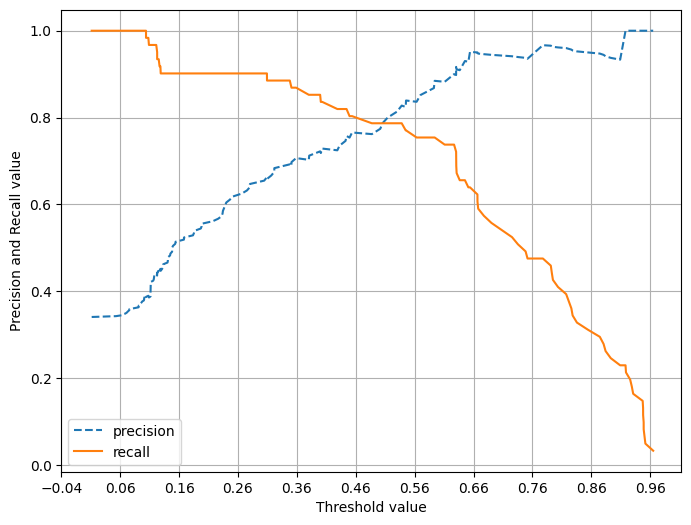

In [69]:
# 정밀도/재현율 시각화

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()


precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

#### 정밀도와 재현율의 맹점

- 정밀도가 100%가 되는 방법: 확실할 때에만 positive로 예측하기
  - ref) 정밀도 = TP/(TP+FP)
- 재현율이 100%가 되는 방법: 모든 환자를 positive로 예측하기
  - ref) 재현율 = TP/(TP+FN)

=> 얼마든지 조작이 가능하므로 정밀도와 재현율의 수치가 적절하게 조합된 평가 지표가 필요

### 3-4. F1 스코어

$$ F1 = \frac{2}{\frac{1}{recall}+\frac{1}{precision}} = 2 * \frac{precision*recall}{precision+recall} $$

정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐.

In [70]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [71]:
# threshold 변화시키면서 평가지표 구해보기 -> F1은 threshold=0.6일 때 가장 높음

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)


임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1: 0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036


### 3-5. ROC 곡선과 AUC

- ROC curve(Receiver Operation Characteristic Curve): FPR(X축)가 변할 때 TPR(Y축)가 어떻게 변하는지를 나타내는 곡선
  - TPR(true positive rate): TP가 정확히 예측되어야 하는 수준    
    -> TP/(FN+TP)
  - TNR(true negative rate): TN가 정확히 예측되어야 하는 수준  
    -> TN/(FP+TN)  
    FPR = 1 - TNR
    
- AUC(Area Under Curve): ROC 곡선 밑의 면적. 1에 가까울수록 좋음

In [72]:
from sklearn.metrics import roc_curve
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1] # 레이블 값이 1일 때의 예측 확률

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

thr_index = np.arange(1,thresholds.shape[0],5)  # 반환된 임곗값 배열에서  5step으로 샘플 추출
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index],2))

print('샘플 임곗값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR: [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


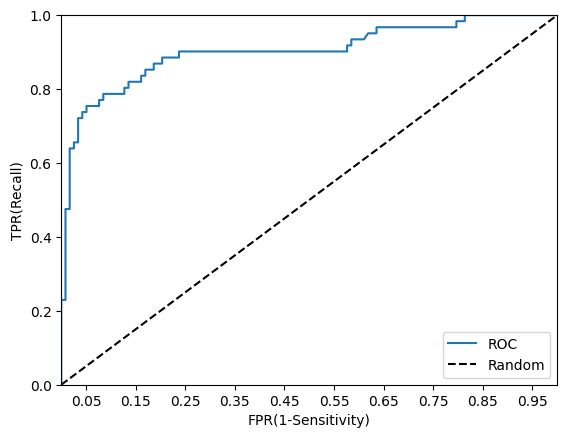

In [73]:
# ROC curve 시각화

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label = 'ROC')
    plt.plot([0,1],[0,1], 'k--', label='Random')  # 가운데 대각선

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1);plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()


roc_curve_plot(y_test, pred_proba[:,1])

In [74]:
# AUC값 구하기

from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9024


In [75]:
# AUC값까지 출력하도록 get_clf_eval() 수정

def get_clf_eval(y_test, pred, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


### 3-6. 피마 인디언 당뇨병 예측

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('/Users/dayoungcho/Desktop/kaggle/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [91]:
diabetes_data.info()   # 딱히 전처리 필요 X

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [98]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify = y)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926, F1: 0.6465, AUC: 0.8083


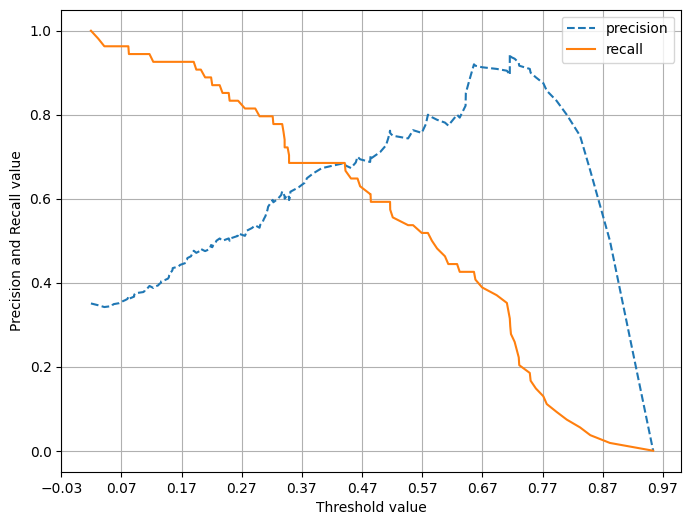

In [99]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)
# 여전히 둘 다 낮음..

In [80]:
diabetes_data.describe()  # min값이 이상한 수치가 많음

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

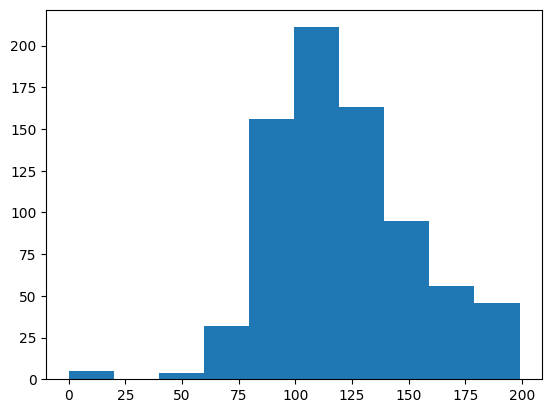

In [81]:
plt.hist(diabetes_data['Glucose'], bins=10)

In [82]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

total_count = diabetes_data['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2: .2f}%'.format(feature, zero_count,100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는  0.65%
BloodPressure 0 건수는 35, 퍼센트는  4.56%
SkinThickness 0 건수는 227, 퍼센트는  29.56%
Insulin 0 건수는 374, 퍼센트는  48.70%
BMI 0 건수는 11, 퍼센트는  1.43%


In [100]:
# 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0,mean_zero_features)

In [108]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

scaler = StandardScaler()   # 데이터셋에 일괄적으로 스케일링 적용
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify = y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC: 0.8433


In [114]:
# threshold 변화에 따른 평가 수치 변화

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):  # get_clf_eval 함수에 변동사항이 있어 함수 재정의 필요
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1) # pred_proba_c1 추가..

thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963, F1: 0.6615, AUC: 0.8433
임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778, F1: 0.6774, AUC: 0.8433
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1: 0.6667, AUC: 0.8433
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037, F1: 0.6667, AUC: 0.8433
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1: 0.6792, AUC: 0.8433
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1: 0.6857, AUC: 0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC: 0.8433
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC: 0.8433


In [115]:
# threshold=0.48로 설정한 Binarizer 생성

binarizer = Binarizer(threshold=0.48)

pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))
get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC: 0.8433
